<a href="https://colab.research.google.com/github/YogitaChaudhari52/Yogita_Chaudhari/blob/main/Final_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Malaria Detection using machine learning

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img
from glob import glob
import cv2

In [34]:
!git clone https://github.com/YogitaChaudhari52/Malaria-Detection-Using-Maching-Learning.git

fatal: destination path 'Malaria-Detection-Using-Maching-Learning' already exists and is not an empty directory.


In [3]:
# using ImageDataGenerator to rescale all images and spliiting with 80% train and 20% validation
data = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

In [4]:
# traini_Set with image_size=(224,224),class_mode='binary' and subset='training'
train_set=data.flow_from_directory(directory='/content/Malaria-Detection-Using-Maching-Learning/cell_images',                           
                                   target_size=(224,224),
                                    class_mode='binary',
                                    batch_size=32,
                                    subset='training'
                                   )

Found 16 images belonging to 2 classes.


In [5]:
# test_set with same features but subset='validation'
test_set=data.flow_from_directory(directory='/content/Malaria-Detection-Using-Maching-Learning/cell_images',
                                   target_size=(224,224),
                                    class_mode='binary',
                                    batch_size=32,
                                    subset='validation'
                                   )

Found 4 images belonging to 2 classes.


VGG Model

In [6]:
# weights initialisation from imagenet nad top layer is not included since we have our own categories
vgg19=VGG19(input_shape=[224,224,3],weights='imagenet',include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [7]:
# we don't want to train the vgg19 model layers again
for layer in vgg19.layers:
    layer.trainable=False

In [8]:
# adding our own flatten layer
x=Flatten()(vgg19.output)
# creating a prediction dense layer with activation of softmax after x layer created above
prediction=Dense(2,activation='softmax')(x)
# model is created with inputs from vgg19 and outputs as our prediction layer
model=Model(inputs=vgg19.input,outputs=prediction)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
# compiling of our customized model
model.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

In [24]:
# fitting our training data and saving results in history 
history = model.fit_generator(generator = train_set,
                              validation_data = test_set,
                              epochs =50)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
1/1 [==============================] - 13s 13s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3502 - val_accuracy: 0.7500
Epoch 2/50
1/1 [==============================] - 13s 13s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3607 - val_accuracy: 0.7500
Epoch 3/50
1/1 [==============================] - 13s 13s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3707 - val_accuracy: 0.7500
Epoch 4/50
1/1 [==============================] - 13s 13s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.3802 - val_accuracy: 0.7500
Epoch 5/50
1/1 [==============================] - 13s 13s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.3892 - val_accuracy: 0.7500
Epoch 6/50
1/1 [==============================] - 13s 13s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.3976 - val_accuracy: 0.7500
Epoch 7/50
1/1 [==============================] - 13s 13s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.4053 - val_accuracy: 0.7500
Epoch 8/50
1/1 [===========

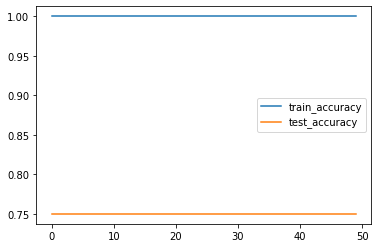

In [25]:
plt.plot(history.history['accuracy'],label='train_accuracy')
plt.plot(history.history['val_accuracy'],label='test_accuracy')
plt.legend()
plt.show()

In [21]:
# saving our model in a .h5 file
from tensorflow.keras.models import load_model
model.save('malaria_vgg19.h5')

In [22]:
y_pred=model.predict(test_set)
y_pred[:10]

array([[0.01159297, 0.98840696],
       [0.03841059, 0.9615894 ],
       [0.9583917 , 0.04160834],
       [0.28256154, 0.71743846]], dtype=float32)

In [23]:
predictions=np.argmax(y_pred,axis=1)
predictions[:10]

array([1, 1, 0, 1])

Resnet

In [26]:
!apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (150 kB/s)
Selecting previously unselected package tree.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [29]:
!mv cell_images train
!mkdir data
!mv train data

mkdir: cannot create directory ‘data’: File exists


In [31]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback
# Imports for diverse utilities
from shutil import copyfile
import matplotlib.pyplot as plt
import operator
from PIL import Image
from sys import intern   # For the symbol definitions